In [1]:
import gct

In [2]:
import os
def run_alg(algname,dataname):
    print("running", algname,dataname)
    retcode = os.system("timeout -k 1h 1h python run_alg.py {} {} 1 >  /data/log/{}_{}.log 2>&1".format(algname,dataname, algname,dataname))
    return retcode


In [3]:
datanames=[ u[1] for u in gct.list_dataset() if u[1].startswith("SIMPLE_ud_wu_nc")]
len(datanames)

254

In [4]:
datanames[:3]        

['SIMPLE_ud_wu_nc128_cz8_in4_it1',
 'SIMPLE_ud_wu_nc128_cz8_in4_it2',
 'SIMPLE_ud_wu_nc128_cz8_in4_it3']

In [5]:
import numpy as np
algs =gct.list_algorithms()
np.random.shuffle(algs)
algs=[u for u in algs if u not in {
    'igraph_community_edge_betweenness',
    'igraph_community_optimal_modularity',
    'snap_Girvan_Newman',
    'cdc_FastCpm',
    'cdc_EAGLE',
    'cdc_CONGA',
    'cdc_HDEMON',
    'cdc_ParCPM'

}]
len(algs)

71

In [6]:
from gct import utils
import os
def has_run(runame, dsname):
    fpath = os.path.join("/{}/tmp/{}_{}.done".format('data', runame,dsname))
    return utils.file_exists(fpath)


In [ ]:
%%time
for algname in ['alg_pg_label_propagation','alg_GossipMap']:
    for dataname in datanames:
        if not has_run(algname,dataname):
            run_alg(algname,dataname)

In [7]:
import numpy as np
arg_list=[]
for algname in algs:
    for dataname in datanames:
        if not has_run(algname,dataname):
            arg_list.append([algname,dataname])
np.random.shuffle(arg_list)
len(arg_list)

4605

In [8]:
def f(ab):
    run_alg(*ab)

In [ ]:
from joblib import Parallel, delayed
Parallel(n_jobs=8)(delayed(f)(u) for u in arg_list)

In [11]:
results = {}
d = gct.list_all_clustering_results(print_format=False)
for u in d:
    if "EVAL_LFR_ud_wu_N" in u:
        for run in d[u]:
            a = gct.load_clustering_result(u, run)
            results[u + run] = a

len(results)

1958

In [101]:
for u in results.values():
    #print( u)
    break

In [23]:
import pandas as pd
df = pd.DataFrame([[u['runname'],u['dataname'],u['timecost'], len(u['clusters'])] for u in results.values()],\
                    columns=['alg','dataname','timecost','#cluster'])

In [47]:
df["N"]=df['dataname'].map(lambda u: int(u.split("_")[-2][1:]))
df["mu"]=df['dataname'].map(lambda u: float(u.split("_")[-1][2:]))

In [25]:
gtdict={dsname:list(gct.load_local_graph(dsname).get_ground_truth().values())[0] for dsname in set(df['dataname'])}


In [36]:
def calc_nmi(dataname,algname):
    gt=gtdict[dataname]
    clu = results[dataname+algname]
    compa = gct.ClusterComparator(gt, clu)            
    return compa.sklean_nmi()

In [ ]:
df['nmi']=df.apply(lambda u: calc_nmi(u['dataname'],u['alg']),axis=1).astype(np.float32)

In [39]:
df['nmi']=df['nmi'].astype(np.float32)

In [50]:
with pd.option_context('display.max_rows', 2000, 'display.max_columns', 200):
    display (df.head())

,alg,dataname,timecost,#cluster,nmi,N,mu
0,alg_pg_label_propagation,EVAL_LFR_ud_wu_N1024_mu0.5,0.687404,1,5.089855e-16,1024,0.5
1,karateclub_SCD,EVAL_LFR_ud_wu_N1024_mu0.5,124.909069,1,5.089855e-16,1024,0.5
2,oslom_lpm,EVAL_LFR_ud_wu_N1024_mu0.5,0.284389,1,5.089855e-16,1024,0.5
3,karateclub_NNSED,EVAL_LFR_ud_wu_N1024_mu0.5,3.923975,12,2.440021e-02,1024,0.5
4,igraph_community_label_propagation,EVAL_LFR_ud_wu_N1024_mu0.5,0.009190,1,5.089855e-16,1024,0.5


In [56]:
with pd.option_context('display.max_rows', 2000, 'display.max_columns', 200):
    a=df[df['N']==1024].sort_values("nmi",ascending=False).head()
    display(a)

,alg,dataname,timecost,#cluster,nmi,N,mu
983,alg_lso_cluster,EVAL_LFR_ud_wu_N1024_mu0.4,0.304516,3,1.0,1024,0.4
994,igraph_community_multilevel,EVAL_LFR_ud_wu_N1024_mu0.4,0.081820,3,1.0,1024,0.4
1632,alg_lso_cluster,EVAL_LFR_ud_wu_N1024_mu0.2,0.257261,3,1.0,1024,0.2
1624,dct_dlslm_map_eq,EVAL_LFR_ud_wu_N1024_mu0.2,0.917408,3,1.0,1024,0.2
1623,oslom_modopt,EVAL_LFR_ud_wu_N1024_mu0.2,8.671986,3,1.0,1024,0.2


In [61]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [98]:
def plot_mu_N(alg,N):
    adf=df[(df['alg']==alg) & (df['N']==N)].sort_values("mu")
    plt.plot(adf["mu"].values,adf["nmi"].values,'-o')
    plt.title("{} N{}".format(alg,N))
    plt.show()
def plot_mu(alg):
    l = []
    for N in set(df["N"]):
        adf=df[(df['alg']==alg) & (df['N']==N)].sort_values("mu")
        plt.plot(adf["mu"].values,adf["nmi"].values,'-o', alpha=0.5)
        l.append(str(N))
    plt.title("{}".format(alg))
    plt.legend(l)
    plt.ylim(-0.1,1.1)
    plt.ylabel('nmi')
    plt.xlabel('mu')
    plt.show()    

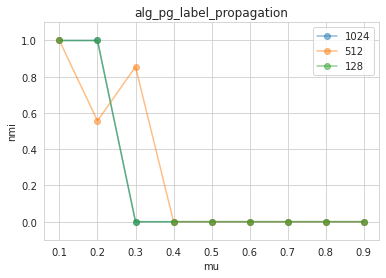

In [102]:
plot_mu('alg_pg_label_propagation')

In [ ]:
for alg in set(df['alg']):
    plot_mu(alg)